# 1. Validation

The following code serves for determining the right exponent of the convective velocity $\alpha$

$u_{dis} = u_0 * (1-x^{\alpha})$

Inputs are:
- alpha = List with exponent's values. should be as few as possible. Computationally very expensive
- experiment = The type of substance being analysed ("2mmol_21C", "2mmol_30C", "5mmol_30C", "10mmol_21C", "10mmol_30C", "15mmol_20C", "15mmol_30C")

alpha=  3.0
dpz_m=  [0.322  0.3108 0.2996 0.2744 0.2548 0.224  0.21   0.1792]
dpz_e=  [0.4315 0.3454 0.3395 0.3542 0.3698 0.3424 0.2935 0.2309] 

alpha=  4.0
dpz_m=  [0.3276 0.3164 0.3052 0.28   0.2604 0.2408 0.2184 0.2408]
dpz_e=  [0.4315 0.3454 0.3395 0.3542 0.3698 0.3424 0.2935 0.2309] 



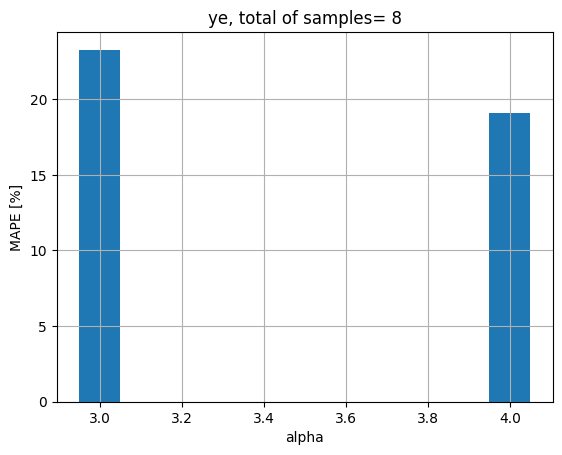

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import helper_functions as hf
from sim_run import run_sim
import csv
from sim_run_parallel_validation import parallel_simulation

alpha = [3.0, 4.0]
experiment = "ye"
dV_ges_ye = 160
total_guess = np.zeros(len(alpha))
total_mape = np.zeros(len(alpha))
dpz_m_history = []
N_CPU = 8
sheet_name = "main" if experiment == "ye" else "sozh"
df = pd.read_excel("Input/data_main.xlsx", sheet_name=sheet_name)
if (experiment =="2mmol_21C"):
    tests = [1, 9, 19]
    dpz_e = [0, 0, 1]
elif(experiment=="2mmol_30C"):
    tests = [32, 42]
    dpz_e = [1, 1]
elif(experiment=="5mmol_30C"):
    tests = [78, 104]
    dpz_e = [1, 1]
elif(experiment=="10mmol_21C"):
    tests = [146, 111, 116, 149, 120, 152, 155, 122, 158, 157, 132, 160, 137, 143]
    dpz_e = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
elif(experiment=="10mmol_30C"):
    tests = [176, 174, 182, 181, 189, 188, 196, 194, 203, 201, 220, 229]
    dpz_e = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
elif(experiment=="15mmol_20C"):
    tests = [237, 236, 245, 243, 252, 250, 258, 255, 265, 262, 273, 269, 282, 292]
    dpz_e = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
elif(experiment=="15mmol_30C"):
    tests = [300, 299, 307, 306, 314, 312, 321, 318, 328, 325, 338, 332, 347, 357]
    dpz_e = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
elif(experiment=="ye"):
    tests = df[(df['dpz_flooded'] != -1) & (df['dV_ges'] == dV_ges_ye)].index
    dpz_e = np.array(df['L_DPZ'][tests])
else:
    raise('Unrecognized experiment name')


df = df.iloc[tests]
exp = df['exp'].tolist()
phi_0 = df['phi_0'].tolist()
dV_ges = df['dV_ges'].tolist()
eps_0 = df['eps_0'].tolist()
if (experiment != "ye"):
    h_c_0 = df['h_c_0'].tolist()
    h_dis_0 = df['h_dis_0'].tolist()

for k in range(len(alpha)):    
    
    dpz_m = np.zeros(len(dpz_e))
    guess = 0
    diff = np.zeros(len(dpz_e))

    exponent = alpha[k]

    if (experiment == "ye"):
        parameters = [(exp[i], phi_0[i], dV_ges[i], eps_0[i], exponent) for i in range(len(exp))]
    else:
        parameters = [(exp[i], phi_0[i], dV_ges[i], eps_0[i], h_c_0[i], h_dis_0[i], exponent) for i in range(len(exp))]
        
    results = joblib.Parallel(n_jobs=N_CPU, backend='multiprocessing')(joblib.delayed(parallel_simulation)(param) for param in parameters)

    for j in range(len(results)):
        if (experiment == 'ye'):
            dpz_m[j] = results[j]['L_DPZ']
            denominator = dpz_e[j] if dpz_e[j] != 0 else dpz_m[j]
            diff [j] = abs((dpz_e[j]-dpz_m[j])/denominator)
        else:
            dpz_m[j] = 1 if (results[j]['dpz_flooded']) else 0
            if (dpz_m[j]==dpz_e[j]):
                guess +=1
            else:
                continue
    print('alpha= ', exponent)
    print('dpz_m= ', dpz_m)
    print('dpz_e= ', dpz_e, '\n')
    dpz_m_history.append(dpz_m)
    total_guess[k] = guess
    total_mape[k] = np.mean(diff) * 100

if (experiment=='ye'):
    df_out = pd.DataFrame({
        "experiment": experiment,
        "alpha": alpha,
        "total_mape": total_mape.astype(int),
        "total_exp":len(tests)
    })
    fname = f"{experiment}_{dV_ges_ye}_alpha_{alpha[0]}_{alpha[-1]}.csv"
    df_out.to_csv(fname, index=False)
else:
    df_out = pd.DataFrame({
        "experiment": experiment,
        "alpha": alpha,
        "total_guess": total_guess.astype(int),
        "total_exp":len(tests),
        "total_guess_p": (total_guess.astype(int)/len(tests))
    })
    fname = f"{experiment}_alpha_{alpha[0]}_{alpha[-1]}.csv"
    df_out.to_csv(fname, index=False)


if (experiment=='ye'):
    plt.bar(alpha, total_mape, width=0.1)
    plt.ylabel('MAPE [%]')
else:
    plt.bar(alpha, 100*total_guess/len(tests), width=0.1)
    plt.ylabel('Correct guess [%]')
plt.xlabel('alpha')
plt.title(f'{experiment}, total of samples= {len(tests)}')
plt.grid()
plt.show()

alpha=  5
dpz_m=  [0.3724 0.3556 0.3332 0.308  0.28   0.2576 0.2324 0.21   0.1904]
dpz_e=  [0.56   0.56   0.56   0.56   0.56   0.4593 0.3637 0.325  0.2624] 

alpha=  5.5
dpz_m=  [0.3724 0.3556 0.3332 0.308  0.28   0.2576 0.2324 0.21   0.1904]
dpz_e=  [0.56   0.56   0.56   0.56   0.56   0.4593 0.3637 0.325  0.2624] 

alpha=  6
dpz_m=  [0.3724 0.3556 0.3332 0.308  0.28   0.2576 0.2324 0.21   0.1904]
dpz_e=  [0.56   0.56   0.56   0.56   0.56   0.4593 0.3637 0.325  0.2624] 

alpha=  6.25
dpz_m=  [0.3724 0.3556 0.3332 0.308  0.28   0.2576 0.2324 0.21   0.1904]
dpz_e=  [0.56   0.56   0.56   0.56   0.56   0.4593 0.3637 0.325  0.2624] 



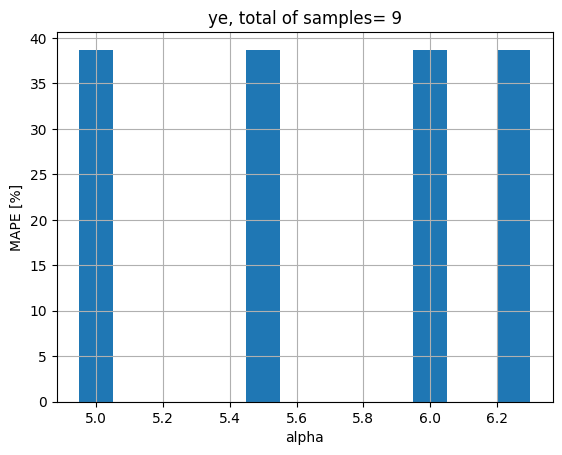

In [ ]:
if (exp=='2mmol_21C'):
    exponent = 1.75
elif(exp=='2mmol_30C'):
    exponent = 10
elif(exp=='5mmol_30C'):
    exponent = 10
elif(exp=='10mmol_21C' or exp=='10mmol_30C'):
    exponent = 1.75
elif(exp=='15mmol_20C'):
    exponent = 1.84
elif(exp=='15mmol_30C'):
    exponent=2.6
elif(exp=='ye' and dV_ges==160):
    exponent = 4.5
elif(exp=='ye' and dV_ges==200):
    exponent = 5.4
elif(exp=='ye' and dV_ges==240):
    exponent = 6.25
elif(exp=='ye' and dV_ges==280):
    exponent = 5.4
else:
    exponent = 1.75


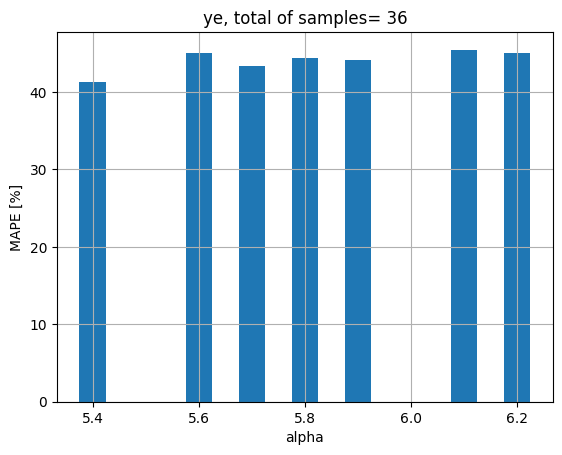

In [2]:
if (experiment=='ye'):
    plt.bar(alpha, total_mape, width=0.05)
    plt.ylabel('MAPE [%]')
else:
    plt.bar(alpha, 100*total_guess/len(tests), width=0.1)
    plt.ylabel('Correct guess [%]')
plt.xlabel('alpha')
plt.title(f'{experiment}, total of samples= {len(tests)}')
plt.grid()
plt.show()

Code for saving results in a csv file:

In [13]:
df_out = pd.DataFrame({
    "experiment": experiment,
    "alpha": alpha,
    "total_guess": total_guess.astype(int),
    "total_exp":len(tests),
    "total_guess_p": (total_guess.astype(int)/len(tests))
})
fname = f"{experiment}_alpha_{alpha[0]}_{alpha[-1]}.csv"
df_out.to_csv(fname, index=False)



df_cmp = pd.DataFrame(dpz_m_history, index=[f"alpha={a}" for a in alpha])
df_cmp.loc["dpz_e"] = dpz_e
df_cmp = df_cmp.loc[["dpz_e"] + [f"alpha={a}" for a in alpha]]

NameError: name 'alpha' is not defined

## Information about tests

All the tests are contained in data_main.xlsx. For filtering per experiment, the following information is needed:

In [44]:
if (experiment =="2mmol_21C"):
    tests = [1, 9, 19]
    dpz_e = [0, 0, 1]
elif(experiment=="2mmol_30C"):
    tests = [32, 42]
    dpz_e = [1, 1]
elif(experiment=="5mmol_30C"):
    tests = [78, 104]
    dpz_e = [1, 1]
elif(experiment=="10mmol_21C"):
    tests = [146, 111, 116, 149, 120, 152, 155, 122, 158, 157, 132, 160, 137, 143]
    dpz_e = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
elif(experiment=="10mmol_30C"):
    tests = [176, 174, 182, 181, 189, 188, 196, 194, 203, 201, 220, 229]
    dpz_e = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
elif(experiment=="15mmol_20C"):
    tests = [237, 236, 245, 243, 252, 250, 258, 255, 265, 262, 273, 269, 282, 292]
    dpz_e = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
elif(experiment=="15mmol_30C"):
    tests = [300, 299, 307, 306, 314, 312, 321, 318, 328, 325, 338, 332, 347, 357]
    dpz_e = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
else:
    raise('Unrecognized experiment name')

TypeError: exceptions must derive from BaseException

In [12]:
import pandas as pd
experiment = 'ye'
sheet_name = "main" if experiment == "ye" else "sozh"
df = pd.read_excel("Input/data_main.xlsx", sheet_name=sheet_name)
dpz_e = df['dpz_flooded']

indices = df[(df['dpz_flooded'] != -1) & (df['dV_ges'] == 160)].index
print(indices)
print(df['dpz_flooded'][indices])
print(df['dV_ges'][indices])

Index([0, 1, 2, 3, 4, 5, 6, 7], dtype='int64')
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
Name: dpz_flooded, dtype: int64
0    160
1    160
2    160
3    160
4    160
5    160
6    160
7    160
Name: dV_ges, dtype: int64
